### Clustering Algorithms

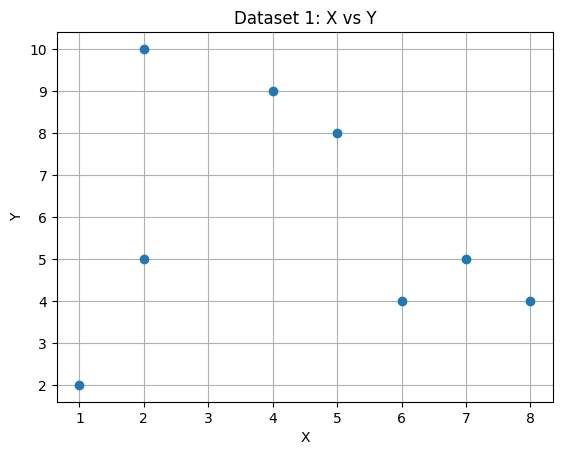

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from copy import copy, deepcopy
import random
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import accuracy_score


class DataPoint:
    def __init__(self, x, y, cluster_number=None,color=None,actual_target_value=None,predicted_target_value=None):
        self.x = x
        self.y = y
        self.cluster_number = cluster_number
        self.color=color
        self.actual_target_value=actual_target_value
        self.predicted_target_value=predicted_target_value

    def set_cluster_number(self, cluster_number):
        self.cluster_number = cluster_number

    def calculate_euclidean_distance(self,midpoint):
        return ((self.x-midpoint.x)**2+(self.y-midpoint.y)**2)**0.5

    def print_data_point(self):
        print("("+str(self.x)+","+str(self.y)+") Cluster:"+str(self.cluster_number)+"",)

    def clear_cluster_number(self):
        self.cluster_number = None

class DataSet:
    def __init__(self):
      self.data_points = []

    def add_data_point(self, data_point):
        self.data_points.append(data_point)

    def initialize_data_points(self,data):
        for i in range(len(data)):
           self.add_data_point(DataPoint(data[i][0],data[i][1]))

    def initialize_datapoints_with_target(self,data,y):
        for i in range(len(data)):
           self.add_data_point(DataPoint(data[i][0],data[i][1],None,None,y[i]))

    def get_data_points(self):
        return  self.data_points

    def print_data_set(self):
        for point in self.data_points:
            point.print_data_point()

    def clear_datapoints_cluster_number(self):
        for point in self.data_points:
            point.clear_cluster_number()

class Midpoint:
     def __init__(self, x, y, cluster_number=None,color=None):
        self.x = x
        self.y = y
        self.cluster_number = cluster_number
        self.total_x=0
        self.total_y=0
        self.cluster_size=0
        self.color=color
        self.cluster_class=None

     def update_midpoint(self):
        self.x = self.total_x/self.cluster_size
        self.y = self.total_y/self.cluster_size
        self.total_x=0
        self.total_y=0
        self.cluster_size=0

     def add_x_value(self,x_value):
        self.total_x += x_value

     def add_y_value(self,y_value):
        self.total_y += y_value

     def increment_cluster_size(self):
        self.cluster_size+=1

     def print_midpoint(self):
         print("("+str(self.x)+","+str(self.y)+") Cluster:"+str(self.cluster_number)+"")

#kmeans clustering algorithm
class Kmeans_Clustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.final_centroids=None
        self.final_dataset=None
        self.final_training_data=None

    def fit(self, iteration, midpoints, dataset,x_label=None,y_label=None,title=None,should_plot=False,print_stats=False):
        counter=0
        #iterate for the defined set of iteration
        for i in range(iteration):
            counter+=1
            for data in dataset:
                nearest_midpoint=None
                prev_ED=0
                #calculate the nearest midpoint to the datapoint
                for midpoint in midpoints:
                    current_ED =  data.calculate_euclidean_distance(midpoint)
                    if(nearest_midpoint==None):
                       nearest_midpoint=midpoint
                       prev_ED=current_ED
                    elif(prev_ED>current_ED):
                       nearest_midpoint=midpoint
                       prev_ED=current_ED
                #update datapoints' cluster number/color with that of the nearest midpoint
                data.set_cluster_number(nearest_midpoint.cluster_number)
                data.color=nearest_midpoint.color
                #update nearest midpoints' total_x, total_y, and cluster_size
                nearest_midpoint.add_x_value(data.x)
                nearest_midpoint.add_y_value(data.y)
                nearest_midpoint.increment_cluster_size()
            #update midpoints
            self.update_midpoints(midpoints)
            #print centroids+datapoint
            if(print_stats):
              self.print_centroids_and_dataset(midpoints,dataset,counter)
            #plot the graph for each of the iteration
            if(should_plot):
               self.plot_graph(midpoints,dataset,x_label,y_label,title,counter)
            #save the final value to the class
        self.final_centroids = midpoints
        self.final_dataset = dataset
        return midpoints,dataset

    def fit_auto(self,midpoints, dataset):
        iteration=0
        continue_loop=True
        while(continue_loop):
            prev_midpoint=deepcopy(midpoints)
            self.fit(1,midpoints,dataset)
            continue_loop= self.check_convergence(midpoints, prev_midpoint)
            iteration +=1
        print("Iterations needed to converge: "+ str(iteration-1))
        return (iteration-1)

    def check_convergence(self,midpoints, prev_Midpoints):
        epsilon = 0.001
        for i in range (self.n_clusters):
            if((abs(prev_Midpoints[i].x-midpoints[i].x)>epsilon) and (abs(prev_Midpoints[i].y-midpoints[i].y)>epsilon)):
               return True
        return False

    def update_midpoints(self,midpoints):
        for midpoint in midpoints:
            midpoint.update_midpoint()

    def plot_graph(self,midpoints,dataset,x_label,y_label,title, iteration):
        legend_labels = []
        colors = []
        counter = 0
        for midpoint in midpoints:
          counter +=1
          legend_labels.append("Cluster "+str(counter))
          colors.append(midpoint.color)
          plt.plot(midpoint.x, midpoint.y,'x',color=midpoint.color)
        for data in dataset:
          plt.plot(data.x, data.y, 'o',color=data.color)
        legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(colors))]
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title+" [Iteration: "+str(iteration)+"]")
        plt.legend(legend_handles, legend_labels)
        plt.grid(True)
        plt.show()
        print("\n\n")

    def print_centroids_and_dataset(self,midpoints,dataset,counter):
        print("------> Iteration: "+ str(counter))
        print("Dataset:")
        for i in range (len(dataset)):
            dataset[i].print_data_point()
        print("Centroids:")
        for midpoint in midpoints:
            midpoint.print_midpoint()
        print("\n")

    def classify_cluster(self,cluster_1,cluster_2):
        total_cluster_1_1 = 0
        total_cluster_2_1 = 0
        #step 1: find the majority class in each of the chosen cluster
        for data in self.final_dataset:
            if data.cluster_number==cluster_1:
               if data.actual_target_value==0:
                  total_cluster_1_1 += 1
            elif data.cluster_number==cluster_2:
               if data.actual_target_value==0:
                  total_cluster_2_1 += 1
        #step 2: classify the midpoints
        for midpoint in self.final_centroids:
            if midpoint.cluster_number == cluster_1:
                if total_cluster_1_1> total_cluster_2_1:
                  midpoint.cluster_class=0
                else:
                  midpoint.cluster_class=1
            elif midpoint.cluster_number == cluster_2:
                if total_cluster_2_1> total_cluster_1_1:
                   midpoint.cluster_class=0
                else:
                   midpoint.cluster_class=1

    def calculate_accuracy(self):
        #variables used to perform accuracy report
        y_actual=[]
        y_predicted=[]
        for data in self.final_training_data:
            y_actual.append(data.actual_target_value)
            y_predicted.append(data.predicted_target_value)
        #compare actual target value with the predicted target value
        confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
        disp.plot(cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()
        # Calculate accuracy from the confusion matrix
        accuracy = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
        return  accuracy
    def predict(self, training_dataset):
      #use midpoints to classify the training data
        for data in training_dataset:
            nearest_midpoint= None
            ED_prev=None
            for midpoint in self.final_centroids:
              ED_current = data.calculate_euclidean_distance(midpoint)
              if(nearest_midpoint==None):
                nearest_midpoint=midpoint
                ED_prev = ED_current
              elif(ED_current<ED_prev):
                nearest_midpoint=midpoint
                ED_prev = ED_current
            data.cluster_number = nearest_midpoint.cluster_number
            data.color = nearest_midpoint.color
            data.predicted_target_value=nearest_midpoint.cluster_class
        self.final_training_data=training_dataset
        return training_dataset

def print_midpoints(midpoints):
    for midpoint in midpoints:
        midpoint.print_midpoint()


In [ ]:

class Nearest_Neighbour_Clustering:
      def __init__(self, k=1):
          self.k=k
          cmap = plt.get_cmap('tab10')
          num_colors = 20
          segment_size = 1.0 / num_colors
          self.color_set = [cmap(segment_size * i) for i in range(num_colors)]
          np.random.shuffle(self.color_set)
          self.final_dataset = None
          self.final_training_data=None
          self.cluster_dic={}

      def fit(self,datapoints,threshold,x_label=None,y_label=None,title=None,should_plot=False):
          for i in range(len(datapoints)):
              nearest_neighbour=None
              prev_ED=0
              current_ED=0
              for j in range(i):
                current_ED = datapoints[i].calculate_euclidean_distance(datapoints[j])
                if(nearest_neighbour==None):
                  nearest_neighbour=datapoints[j]
                  prev_ED=current_ED
                elif(prev_ED>current_ED):
                  nearest_neighbour=datapoints[j]
                  prev_ED=current_ED
              if(i==0):
                datapoints[i].set_cluster_number(self.k)
                datapoints[i].color = self.color_set[self.k]
                self.k += 1
              elif(prev_ED<threshold):
                datapoints[i].set_cluster_number(nearest_neighbour.cluster_number)
                datapoints[i].color = nearest_neighbour.color
              else:
                datapoints[i].set_cluster_number(self.k)
                datapoints[i].color = self.color_set[self.k]
                self.k += 1
          if(should_plot):
            self.plot_graph(datapoints,x_label,y_label,title)
          self.final_dataset = datapoints
          return datapoints

      def plot_graph(self,datapoints,x_label,y_label,title):
          for datapoint in datapoints:
              plt.plot(datapoint.x, datapoint.y,'o',color=datapoint.color)
          colors=[]
          legend_labels=[]
          for i in range(self.k-1):
            colors.append(self.color_set[i+1])
            legend_labels.append("Cluster "+str(i+1))
          legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(colors))]
          plt.xlabel(x_label)
          plt.ylabel(y_label)
          plt.title(title)
          plt.legend(legend_handles, legend_labels)
          plt.grid(True)
          plt.show()
          print("\n\n")

      def classify_cluster(self,cluster_1,cluster_2):
        total_cluster_1_1 = 0
        total_cluster_2_1 = 0
        #step 1: find the majority class in each of the chosen cluster
        for data in self.final_dataset:
            if data.cluster_number==cluster_1:
               if data.actual_target_value==0:
                  total_cluster_1_1 += 1
            elif data.cluster_number==cluster_2:
               if data.actual_target_value==0:
                  total_cluster_2_1 += 1
        if total_cluster_1_1>total_cluster_2_1:
            self.cluster_dic[cluster_1]=0
            self.cluster_dic[cluster_2]=1
        else:
            self.cluster_dic[cluster_1]=1
            self.cluster_dic[cluster_2]=0


      def predict(self, training_dataset, threshold, c1,c2):
      #use midpoints to classify the training data
        for test_data in training_dataset:
           #define dictionary
            NNC_dict = {}
            NNC_dict[c1]=0
            NNC_dict[c2]=0
            #omit all clusters aside from the two chosen clusters
            for train_data in self.final_dataset:
                if train_data.cluster_number != None and train_data.calculate_euclidean_distance(test_data)<threshold and (train_data.cluster_number ==c1 or train_data.cluster_number ==c2):
                    NNC_dict[train_data.cluster_number] += 1
            if len(NNC_dict) != 0:
               nearest_cluster_number=max(NNC_dict, key=NNC_dict.get)
               test_data.predicted_target_value = self.cluster_dic[nearest_cluster_number]
            self.final_training_data=training_dataset
        return training_dataset

      def calculate_accuracy(self):
        #variables used to perform accuracy report
        y_actual=[]
        y_predicted=[]
        for data in self.final_training_data:
            if(data.predicted_target_value != None):
              y_actual.append(data.actual_target_value)
              y_predicted.append(data.predicted_target_value)
        #compare actual target value with the predicted target value
        confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
        disp.plot(cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()
        # Calculate accuracy from the confusion matrix
        accuracy = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
        return  accuracy


In [ ]:

class DBscan_Clustering:
    def __init__(self,epsilon,minpoint):
        cmap = plt.get_cmap('tab10')
        num_colors = 20
        segment_size = 1.0 / num_colors
        self.color_set = [cmap(segment_size * i) for i in range(num_colors)]
        np.random.shuffle(self.color_set)
        self.epsilon =epsilon
        self.minpoint = minpoint
        self.k=1
        self.final_dataset = None
        self.final_training_data=None
        self.cluster_dic={}

    def fit(self,datapoints,x_label=None,y_label=None,title=None,should_plot=False):
        for i in range(len(datapoints)):
            cluster=[]
            #horizontal check
            for j in range(i+1,len(datapoints)):
                if(datapoints[i].calculate_euclidean_distance(datapoints[j])<=self.epsilon):
                  cluster.append(datapoints[j])
                  #update cluster
                  self.update_cluster(datapoints,i,j)
            #vertical check
            for z in range(0,i):
                if(datapoints[i].calculate_euclidean_distance(datapoints[z])<=self.epsilon):
                  cluster.append(datapoints[z])
                  #update cluster
                  self.update_cluster(datapoints,i,z)
            #create new cluster
            if(len(cluster)+1>=self.minpoint and datapoints[i].cluster_number==None ):
                  datapoints[i].cluster_number=self.k
                  datapoints[i].color=self.color_set[self.k-1]
                  for datapoint in cluster:
                      datapoint.cluster_number= datapoints[i].cluster_number
                      datapoint.color=datapoints[i].color
                  self.k +=1
        if(should_plot):self.plot_graph(datapoints,x_label,y_label,title)
        self.final_dataset = datapoints
        return datapoints

    def update_cluster(self,datapoints,x,y):
        if(datapoints[y].cluster_number != None and datapoints[x].cluster_number==None):
             datapoints[x].cluster_number= datapoints[y].cluster_number
             datapoints[x].color= datapoints[y].color
        elif(datapoints[x].cluster_number !=None and datapoints[y].cluster_number != None and datapoints[x].cluster_number>datapoints[y].cluster_number):
             datapoints[x].cluster_number= datapoints[y].cluster_number
             datapoints[x].color= datapoints[y].color
        elif(datapoints[x].cluster_number !=None and datapoints[y].cluster_number != None and datapoints[x].cluster_number<datapoints[y].cluster_number):
             datapoints[y].cluster_number= datapoints[x].cluster_number
             datapoints[y].color= datapoints[x].color
        elif(datapoints[x].cluster_number !=None and datapoints[y].cluster_number == None):
             datapoints[y].cluster_number= datapoints[x].cluster_number
             datapoints[y].color= datapoints[x].color

    def plot_graph(self,datapoints,x_label,y_label,title):
        colors=[]
        legend_labels=[]
        valid = True
        for datapoint in datapoints:
            if(datapoint.color==None):
              plt.plot(datapoint.x, datapoint.y,'o',color='black')
              if(valid):
                legend_labels.append("Outlier")
                colors.append('black')
                valid = False
            else:
              plt.plot(datapoint.x, datapoint.y,'o',color=datapoint.color)
        for i in range(self.k-1):
          colors.append(self.color_set[i])
          legend_labels.append("Cluster "+str(i+1))
        legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(colors))]
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend(legend_handles, legend_labels)
        plt.grid(True)
        plt.show()
        print("\n\n")

    def classify_cluster(self,cluster_1,cluster_2):
        total_cluster_1_1 = 0
        total_cluster_2_1 = 0
        #step 1: find the majority class in each of the chosen cluster
        for data in self.final_dataset:
            if data.cluster_number==cluster_1:
               if data.actual_target_value==0:
                  total_cluster_1_1 += 1
            elif data.cluster_number==cluster_2:
               if data.actual_target_value==0:
                  total_cluster_2_1 += 1
        if total_cluster_1_1>total_cluster_2_1:
            self.cluster_dic[cluster_1]=0
            self.cluster_dic[cluster_2]=1
        else:
            self.cluster_dic[cluster_1]=1
            self.cluster_dic[cluster_2]=0

    def predict(self, training_dataset, threshold, c1,c2):
      #use midpoints to classify the training data
        for test_data in training_dataset:
           #define dictionary
            NNC_dict = {}
            NNC_dict[c1]=0
            NNC_dict[c2]=0
            #omit all clusters aside from the two chosen clusters
            for train_data in self.final_dataset:
                if train_data.cluster_number != None and train_data.calculate_euclidean_distance(test_data)<threshold and (train_data.cluster_number ==c1 or train_data.cluster_number ==c2):
                    NNC_dict[train_data.cluster_number] += 1
            if len(NNC_dict) != 0:
               nearest_cluster_number=max(NNC_dict, key=NNC_dict.get)
               test_data.predicted_target_value = self.cluster_dic[nearest_cluster_number]
            self.final_training_data=training_dataset
        return training_dataset

    def calculate_accuracy(self):
        #variables used to perform accuracy report
        y_actual=[]
        y_predicted=[]
        for data in self.final_training_data:
            if(data.predicted_target_value != None):
              y_actual.append(data.actual_target_value)
              y_predicted.append(data.predicted_target_value)
        #compare actual target value with the predicted target value
        confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix)
        disp.plot(cmap='Blues')
        plt.title('Confusion Matrix')
        plt.show()
        # Calculate accuracy from the confusion matrix
        accuracy = confusion_matrix.diagonal().sum() / confusion_matrix.sum()
        return  accuracy

def plot_initial_graph(x,y,x_label,y_label,title):
    plt.plot(x, y, marker='o', linestyle='', label='points')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

#initialize the required variables
#dataset_1
dataset_1 = np.array([[2, 10],[2, 5],[8, 4],[5, 8],[7, 5],[6, 4],[1, 2],[4, 9]])
d1_x_values = dataset_1[:, 0]
d1_y_values = dataset_1[:, 1]
plot_initial_graph(d1_x_values,d1_y_values,'X','Y','Dataset 1: X vs Y')

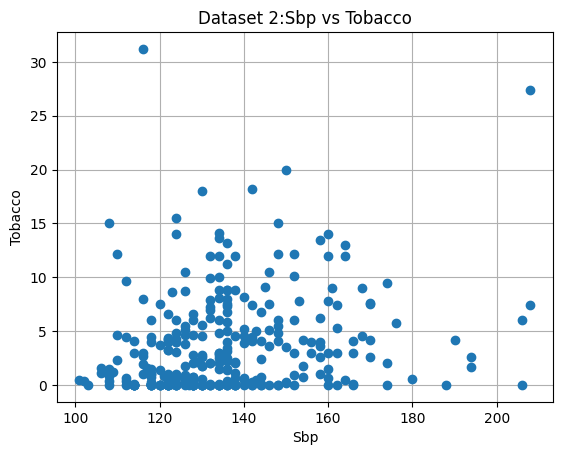

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv')
dataset_2=df[['sbp','tobacco']]
target_value = df['chd']
#training data
dataset_2_training = dataset_2.loc[0:299]
dataset_2_training = np.array(dataset_2_training)
d2_x_values = dataset_2_training[:, 0]
d2_y_values = dataset_2_training[:, 1]
y_train = target_value.loc[0:299]
y_train = np.array(y_train)
#testing data
dataset_2_testing = dataset_2.loc[300:]
dataset_2_testing = np.array(dataset_2_testing)
y_test  = target_value.loc[300:]
y_test = np.array(y_test )
#plot the initial graph of sbh Vs. tobacco
plot_initial_graph(d2_x_values,d2_y_values,"Sbp","Tobacco","Dataset 2:Sbp vs Tobacco")

### K-means Clustering

------> Iteration: 1
Dataset:
(2,10) Cluster:3
(2,5) Cluster:1
(8,4) Cluster:2
(5,8) Cluster:3
(7,5) Cluster:2
(6,4) Cluster:2
(1,2) Cluster:1
(4,9) Cluster:3
Centroids:
(1.5,3.5) Cluster:1
(7.0,4.333333333333333) Cluster:2
(3.6666666666666665,9.0) Cluster:3




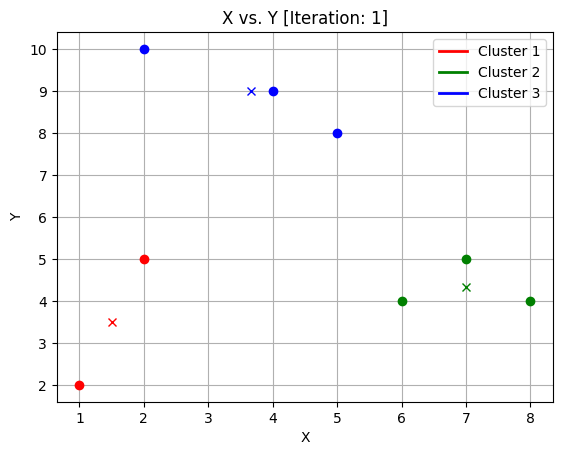

In [ ]:
#midpoints = A2, A3, A8
initial_seed=[ Midpoint(2,5,1,'red'), Midpoint(8,4,2,'green'),Midpoint(4,9,3,'blue')]
#convert dataset_1 to DataPoint
d1_dataset=DataSet()
d1_dataset.initialize_data_points(dataset_1)
kmean = Kmeans_Clustering(3)
#perform k_means clustering for one epoch
kmeans_result=kmean.fit(1, deepcopy(initial_seed), deepcopy(d1_dataset.get_data_points()),'X','Y','X vs. Y',True,True)

Iterations needed to converge: 1
------> Iteration: 1
Dataset:
(2,10) Cluster:3
(2,5) Cluster:1
(8,4) Cluster:2
(5,8) Cluster:3
(7,5) Cluster:2
(6,4) Cluster:2
(1,2) Cluster:1
(4,9) Cluster:3
Centroids:
(1.5,3.5) Cluster:1
(7.0,4.333333333333333) Cluster:2
(3.6666666666666665,9.0) Cluster:3




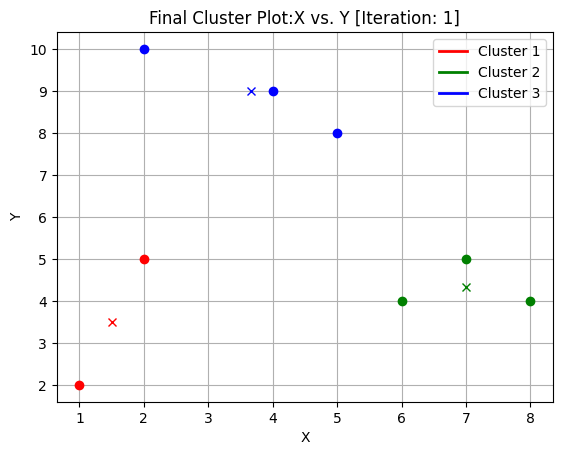

In [ ]:
#iteration to convergence
iteration=kmean.fit_auto(deepcopy(initial_seed), deepcopy(d1_dataset.get_data_points()))
#final plot
kmeans_result=kmean.fit(1, deepcopy(initial_seed), deepcopy(d1_dataset.get_data_points()),'X','Y','Final Cluster Plot:X vs. Y',True,True)

Iterations needed to converge: 2


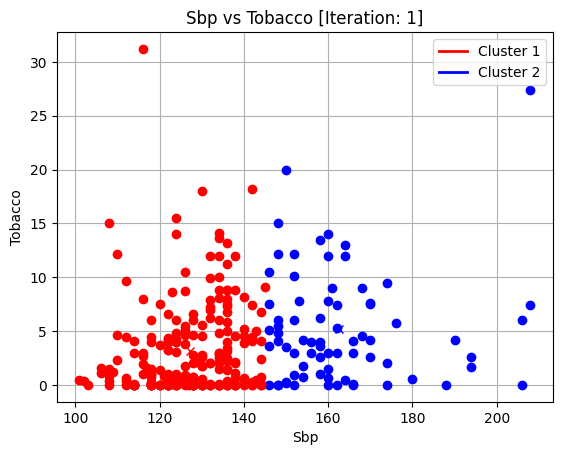

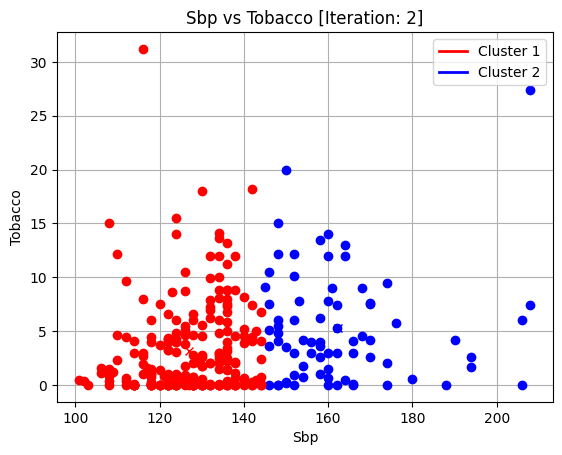




(127.09292035398231,3.1276991150442477) Cluster:1
(162.4189189189189,5.276216216216216) Cluster:2


In [ ]:
#kmeans clustering on the graph sbp vs tobacco
initial_seed=[ Midpoint(130,5,1,'red'),Midpoint(160,5,2,'blue')]
#convert dataset_2 to datapoints
d2_dataset=DataSet()
d2_dataset.initialize_datapoints_with_target(dataset_2_training,y_train)
#kmeans algorithm
kmeans = Kmeans_Clustering(2)
iteration = kmeans.fit_auto(deepcopy(initial_seed),deepcopy(d2_dataset.get_data_points()))
kmeans_result = kmeans.fit(iteration,deepcopy(initial_seed),deepcopy(d2_dataset.get_data_points()),"Sbp","Tobacco","Sbp vs Tobacco",True,False)
print_midpoints(kmeans_result[0])

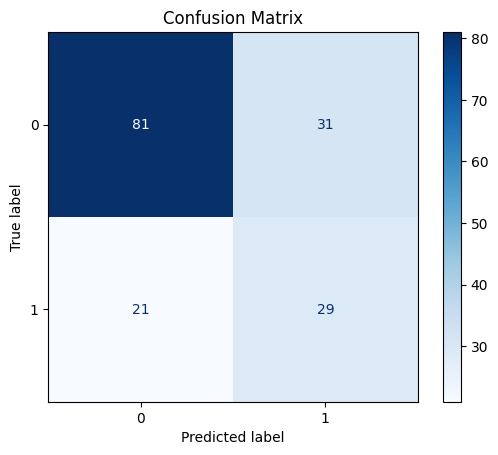

accuracy:  0.6790123456790124


In [ ]:
d2_dataset_test = DataSet()
d2_dataset_test.initialize_datapoints_with_target(dataset_2_testing,y_test)
kmeans.classify_cluster(1,2)
trained_dataset=kmeans.predict(deepcopy(d2_dataset_test.get_data_points()))
print("accuracy: ", kmeans.calculate_accuracy())

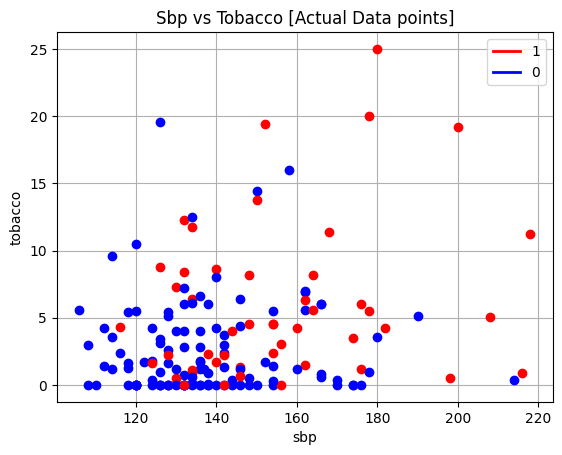

In [ ]:
def plot_graph_type_2(dataset,actual=True):
    legend_labels = []
    colors = []
    legend_labels.append("1")
    legend_labels.append("0")
    colors.append("red")
    colors.append("blue")
    if(actual):
      title="Sbp vs Tobacco [Actual Data points]"
      for data in dataset:
          if(data.actual_target_value==1):plt.plot(data.x, data.y, 'o',color='red')
          else:plt.plot(data.x, data.y, 'o',color='blue')
    else:
      title="Sbp vs Tobacco [Predicted Data points]"
      for data in dataset:
          if(data.predicted_target_value==1):plt.plot(data.x, data.y, 'o',color='red')
          else:plt.plot(data.x, data.y, 'o',color='blue')
    legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(colors))]
    plt.xlabel("sbp")
    plt.ylabel("tobacco")
    plt.title(title)
    plt.legend(legend_handles, legend_labels)
    plt.grid(True)
    plt.show()
    print("\n\n")

#plot actual data points
plot_graph_type_2(trained_dataset,actual=True)

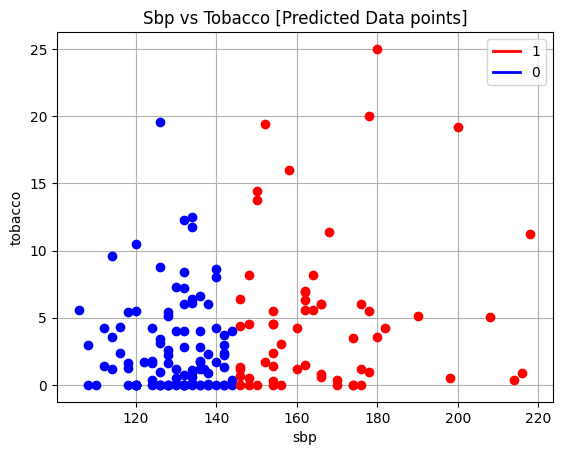

In [ ]:
#plot predicted datapoints
plot_graph_type_2(trained_dataset,actual=False)

### Nearest Neighbor Clustering Algorithm

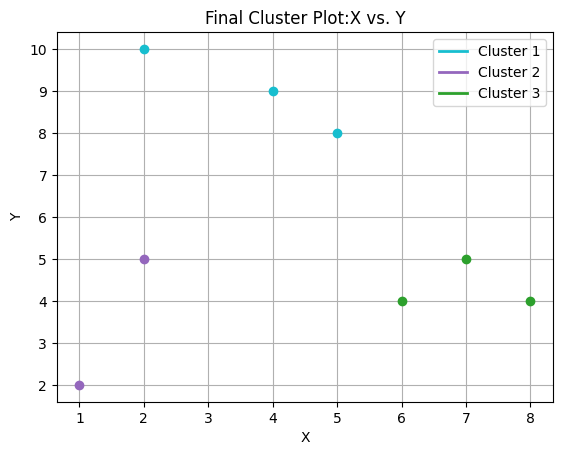

In [ ]:
threshold=4
NNC= Nearest_Neighbour_Clustering()
#perform Nearest Neighbor clustering on dataset 1
NNC_result=NNC.fit(deepcopy(d1_dataset.get_data_points()),threshold,'X','Y','Final Cluster Plot:X vs. Y',True)

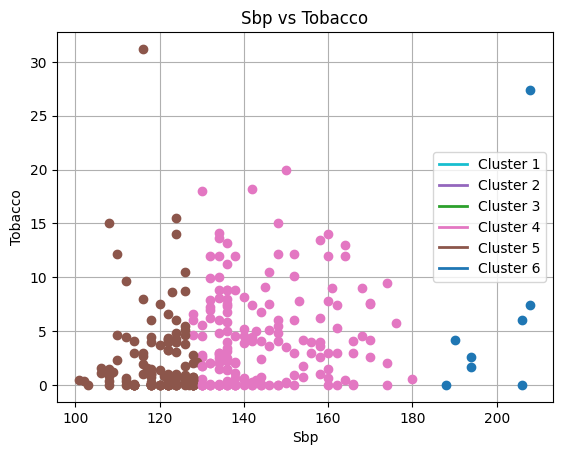

In [ ]:
threshold=23
#perform nearest neighbor clustering on dataset 2
NNC_result = NNC.fit(deepcopy(d2_dataset.get_data_points()),threshold,"Sbp","Tobacco","Sbp vs Tobacco",True)

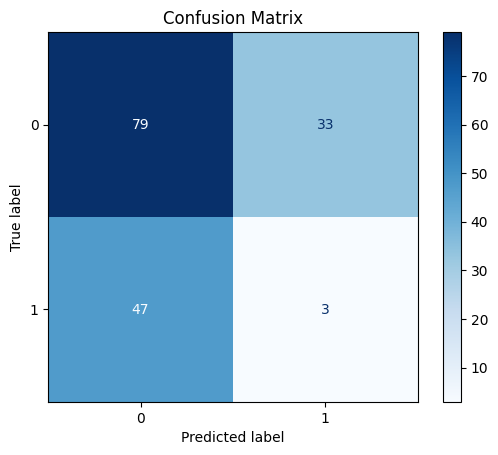

accuracy: 0.5061728395061729


In [ ]:
#use testing data to compute the accuracy
#step 1: Identify the two largest cluster
NNC.classify_cluster(4,5)
#step 2: Use the testing data to predict based on the classification made in step 1
NNC.predict(deepcopy(d2_dataset_test.get_data_points()),threshold,4,5)
#step 3: calculate accuracy
print("accuracy:",NNC.calculate_accuracy())

### DBScan clustering algorithm

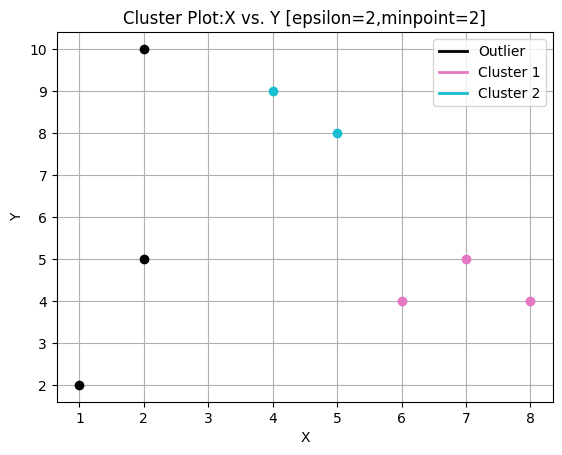

In [ ]:
#epsilon 2, minpoint =2
epsilon=2
minpoint=2
#create model
dbscan = DBscan_Clustering(epsilon,minpoint)
#perform DBS scan on dataset 1
dbscan_result=dbscan.fit(deepcopy(d1_dataset.get_data_points()),'X','Y','Cluster Plot:X vs. Y [epsilon=2,minpoint=2]', True)

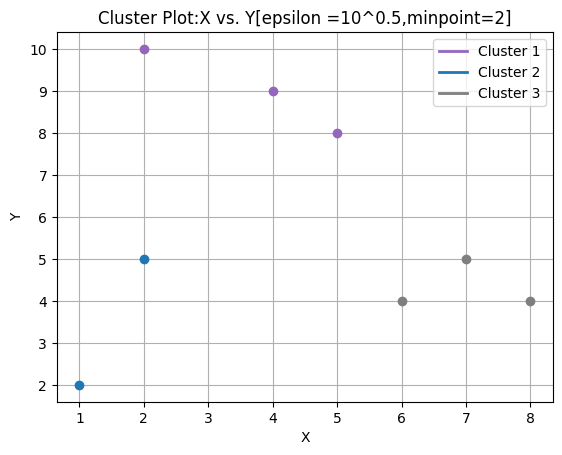

In [ ]:
#epsilon 2, minpoint =2
epsilon=10**0.5
minpoint=2
#create model
dbscan = DBscan_Clustering(epsilon,minpoint)
#perform DBS scan on dataset 1
dbscan_result=dbscan.fit(deepcopy(d1_dataset.get_data_points()),'X','Y','Cluster Plot:X vs. Y[epsilon =10^0.5,minpoint=2]', True)

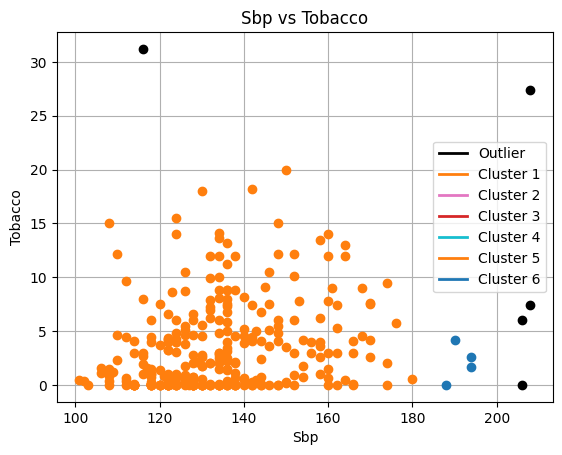

In [ ]:
epsilon=7
minpoint=4
#create model
dbscan = DBscan_Clustering(epsilon,minpoint)
#perform dbscan on dataset 2
dbscan_result=dbscan.fit(deepcopy(d2_dataset.get_data_points()),"Sbp","Tobacco","Sbp vs Tobacco",True)

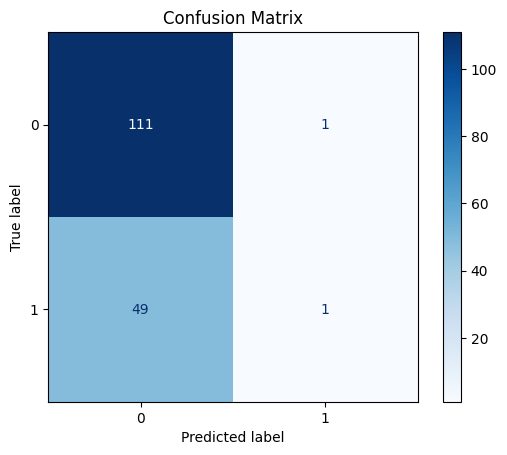

accuracy:  0.691358024691358


In [ ]:
#step 1: classify the two biggest cluster
dbscan.classify_cluster(1,6)
#step 2: predict using the training data wrt to the prev chosen cluster
dbscan.predict(deepcopy(d2_dataset_test.get_data_points()),epsilon,1,6)
#step 3: calculate accuracy
print("accuracy: ",dbscan.calculate_accuracy())

### scikit-learn Implementation

Accuracy: 0.6790123456790124
Midpoints:
Centroid 1: [127.09292035   3.12769912]
Centroid 2: [162.41891892   5.27621622]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


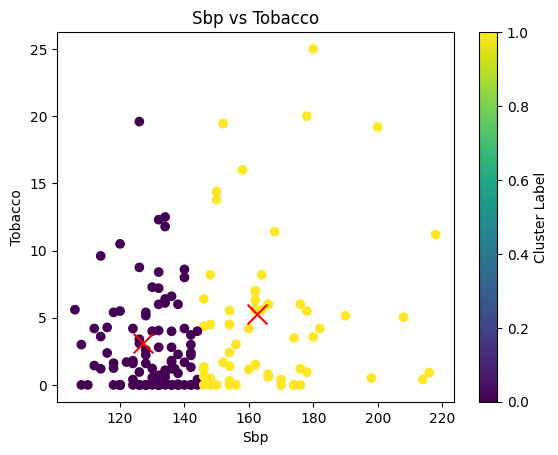

In [ ]:
#Kmneans algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(dataset_2_training)
# Predict using testing data
predicted_clusters = kmeans.predict(dataset_2_testing)
#Calculate accuracy score
accuracy = accuracy_score(y_test, predicted_clusters)
print("Accuracy:", accuracy)
# Visualizing the result
# Plotting the data points
plt.scatter(dataset_2_testing[:, 0], dataset_2_testing[:, 1], c=predicted_clusters)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('Sbp vs Tobacco')
plt.xlabel('Sbp')
plt.ylabel('Tobacco')
plt.colorbar(label='Cluster Label')
# centroids
centroids = kmeans.cluster_centers_
# Print centroids
print("Midpoints:")
for i, centroid in enumerate(centroids):
    print(f"Centroid {i + 1}: {centroid}")

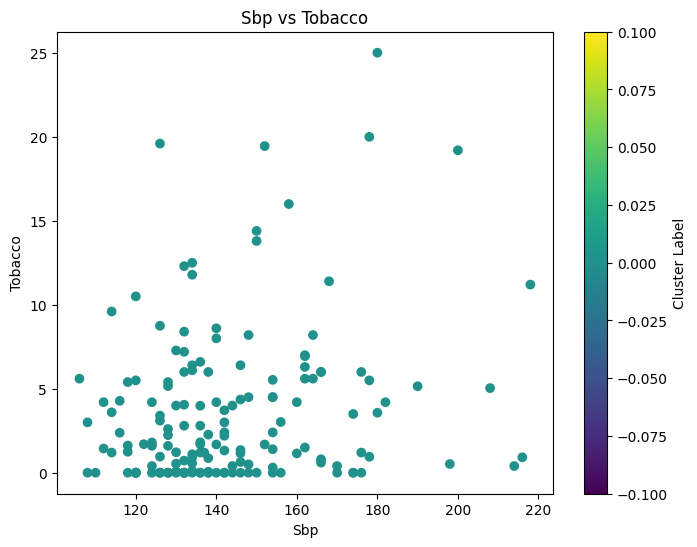

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Fit KNeighborsClassifier model
knn = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors as needed
knn.fit(dataset_2_training, np.zeros(len(dataset_2_training)))
# use testing data to predict
predicted_clusters = knn.predict(dataset_2_testing)
# Visualizing result
plt.figure(figsize=(8, 6))
# Plotting the data points
plt.scatter(dataset_2_testing[:, 0], dataset_2_testing[:, 1], c=predicted_clusters)
plt.title('Sbp vs Tobacco')
plt.xlabel('Sbp')
plt.ylabel('Tobacco')
plt.colorbar(label='Cluster Label')
plt.show()

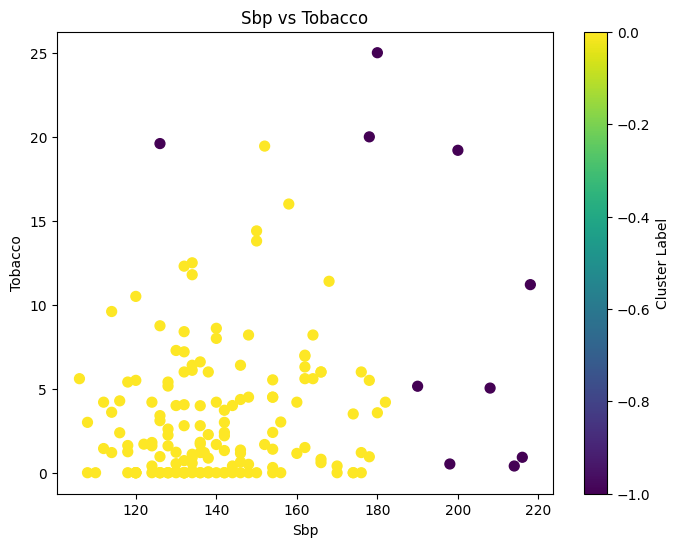

In [ ]:
from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=7, min_samples=4)
predicted_clusters = dbscan.fit_predict(dataset_2_testing)
# Visualizing the clustering result
plt.figure(figsize=(8, 6))
# Plotting the data points
plt.scatter(dataset_2_testing[:, 0], dataset_2_testing[:, 1], c=predicted_clusters, cmap='viridis', s=50)
plt.title('Sbp vs Tobacco')
plt.xlabel('Sbp')
plt.ylabel('Tobacco')
plt.colorbar(label='Cluster Label')
plt.show()